<a href="https://colab.research.google.com/github/aymanish/PADL-Q5-RNN-Time-Predictor/blob/main/Q5_padl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q5**

In [ ]:
# Import all relevant libraries
import zipfile
import os
import shutil
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torch.optim as optim


In [ ]:
# Get training device. This will be the CPU or GPU(cuda) depending on availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# LOAD IMAGES

# Use wget to download the zip file
!wget https://www-users.york.ac.uk/~waps101/PADL/clocks_dataset.zip

The code blocks below refer to part (a) of question 5:

We first create 2 directories for the original data (clocks dataset) as well as a directory for synthetic/augmented data (clocks dataset augmented).

In [ ]:
# Extract the zip file
with zipfile.ZipFile("clocks_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("clocks_dataset")

# List the extracted files
extracted_files = os.listdir("clocks_dataset")
print(extracted_files)



['train']


In [ ]:
resize = 256
#images are resized to 256 by 256 for easier learning and memory capacity of the neural network.
# Given most of the images are mostly empty color spaces we wuld not loose too much information by downscaling
# Keeping them at 448 x448 would unnecessarily increase computation
# Hence we resclae to about half while also ensuring we do not lose necessary features from the image such as numbers

In [ ]:
# Define the paths
train_dir = "clocks_dataset/train"


# Filter for PNG files in the 'train' directory
png_files = [file for file in os.listdir(train_dir) if file.endswith('.png')]
print(f"Total number of images: {len(png_files)}")


Total number of images: 10000


In [ ]:
augmented_dir = "clocks_dataset_augmented"

# Create a directory for augmented data
if os.path.exists(augmented_dir):
    shutil.rmtree(augmented_dir)
os.makedirs(augmented_dir)

After that, we shuffle the image files randomly and then split them 80 : 20 for training and test.

In [ ]:
# Split data into train and test sets - avoid data leakage when augmenting
random.shuffle(png_files)
num_samples = len(png_files)
train_split = int(0.8 * num_samples)

train_files = png_files[:train_split]
test_files = png_files[train_split:]

print(f"Number of training images: {len(train_files)}")
print(f"Number of testing images: {len(test_files)}")

Number of training images: 8000
Number of testing images: 2000


In [ ]:
# Function to read labels from text files
def read_label(file_path):
    with open(file_path, 'r') as f:
        time_str = f.readline().strip()
    hour, minute = map(int, time_str.split(':'))
    return hour, minute

In [ ]:
# Read labels from txt files and append to a labels list
labels = []
for png_file in png_files:
    label_file = os.path.join(train_dir, png_file.replace('.png', '.txt'))
    labels.append(read_label(label_file))

print(f"Total number of labels: {len(labels)}")
print(labels[0])

Total number of labels: 10000
(2, 45)


In [ ]:
# Uncomment and run if clocks_dataset_augmented already exists or requires changing without overwitting
"""
# Path to the directory to delete
directory_path = "clocks_dataset_augmented"

# Remove the directory and all its contents
shutil.rmtree(directory_path)
#"""

'\n# Path to the directory to delete\ndirectory_path = "clocks_dataset_augmented"\n\n# Remove the directory and all its contents\nshutil.rmtree(directory_path)\n#'

All the images in both test and train undergo the basic transform as defined below where they are resized to 256 x 256 pixels. #images are resized to 256 by 256 for easier learning and memory capacity of the neural network.

Given most of the images are mostly empty color spaces we wuld not loose too much information by downscaling. Keeping them at 448 x448 would unnecessarily increase computation. Hence we resclae to about half while also ensuring we do not lose necessary features from the image such as numbers

THe are then converted to Tensors for the Pytorch based neural network and then then tensor image values are normalised between 0 and 1 for smoother learning as the values are now scaled. This transofrmation happens at the very end when the dataloaders are used to fetch the images from the directories.



---

We want to create a copy of the original images and apply transformations and augmentations to create new synthetic data to learn from.

* For these augmentations we have an augment_transform pipeline that applies the same resizing incase an image hasnt already been resized - ensuring consistency.  After that we also apply color jitter which augments the brightness, contrast, saturation and hue of all the images thus providing more variation. We kept them moderately low at 20% variations to the values mentioned above. This is so that we do not augment them too heavily and make our trainng data difficutlt to learn or too different from the test data. Having this accounts for colours and brightness levels that would otherwise be previously unseen.

* We also apply random affine transformations such as scaling, translating and filling any empty spaces afterwards. We implement translation to boost our model to be translation invariant - it should understand that moving the clock has no effect on the features related to the time.

* The same rule applied to scaling. Scaling also provides us with more variation in clock sizes beyond the training images. By doing these in conjuction with the color jitter we are essentially creating new clock datasets that are augmented. We fill the images where they are scaled or translated around the edges with white (the default is black and that could confuse the model into thinking these black edges are the clock hands as most hands are black)

* We do not apply rotation as some of the clocks dont have any numbers on them and rotating them owuld only confuse the model as we normally expect clocks to be facing upright and without any rotation.

* We also apply minor gaussian blur and noise to the images with a 5% chance to allow the model to be more robust to poor quality images or even act as a bit of smoothening features via blurring.

For each origianl image we create 2 augmentations which are stored in the augmented directory. We have 8000 original images. Hence we obtain 800 x 2 = 16000 augmented images. This totals to a training size of 24,000 images.

In [ ]:
# Define the transformation pipeline with augmentation

transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


augment_transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=(255, 255, 255)), # Added fillcolor
    transforms.RandomApply([
        transforms.Lambda(lambda img: transforms.ToPILImage()(transforms.ToTensor()(img) + torch.randn_like(transforms.ToTensor()(img)) * 0.05))
    ], p=0.05),  # Add random noise and convert back to PIL Image
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2))], p=0.05)  # Apply Gaussian blur
])

print(f"Total number of original images: {len(train_files)}")

# Number of augmented images to generate per original image
num_augmentations = 2


# Generate and save augmented images from training data
for img_file in train_files:
    image = Image.open(os.path.join(train_dir, img_file)).convert('RGB')
    for i in range(num_augmentations):
        augmented_image = augment_transform(image)
        augmented_image_path = os.path.join(augmented_dir, f"{img_file.split('.')[0]}_aug_{i}.png")
        augmented_image.save(augmented_image_path)

# Verify augmented dataset size
augmented_files = [file for file in os.listdir(augmented_dir) if file.endswith('.png')]
print(f"Total number of augmented images: {len(augmented_files)}")

Total number of original images: 8000
Total number of augmented images: 16000


We then implement 2 dataloaders for the original images and the augmented dataset. Both datasets fetch the image and label data only when needed using the getitem function, preventing the need to load all the data into memory at once. To facilitate this the datasets are loaded with information such as the image directories.

We load correnponding labels for each image by reading the associated text files.

This makes dataloading more efficient overall as we are implementing on demand data loading. We also apply any transofrmations and rgb conversions when we are requested to get the image and not before further saving memory and efficiency.



---

The augmented images dataloader works mostly the smae with a few minor tweaks. We load both the original directory and augmented directory It is importantt to note that they are using the same labels so the number of labels are not changing for the augmented images. we retain the filenames of the original image files and only add 'aug' followed by the number of augmentations ( so 0 and 1 since we augment each image twice)

Both dataloaders return the transformed image and a tensor containig the labels for hour and minutes.

In [ ]:
# Custom dataset class for loading clock images and their corresponding time labels
class ClockDataset(Dataset):
    def __init__(self, image_dir, image_files, transform=None):
        # Initialize with image directory, list of image files, and chosen transformations
        self.image_dir = image_dir
        self.image_files = image_files
        self.transform = transform
        self.labels = self.load_labels()

    def load_labels(self):
        labels = []
        # Load labels from text files corresponding to each image
        for image_file in self.image_files:
            label_file = os.path.join(self.image_dir, image_file.replace('.png', '.txt'))
            labels.append(self.read_label(label_file))
        return labels

    def read_label(self, file_path):
      # Read the time label from the text file
        with open(file_path, 'r') as f:
            time_str = f.readline().strip()
        hour, minute = map(int, time_str.split(':'))
        return hour, minute

    def __len__(self):
      # Return the number of images
        return len(self.image_files)

    def __getitem__(self, idx):
      # Get the image and corresponding label at the specified index and convert to RGB and apply transformation
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        hour, minute = self.labels[idx]

        return image, torch.tensor([hour, minute], dtype=torch.float32)

# Custom dataset class for loading augmented images
class AugmentedClockDataset(Dataset):
    def __init__(self, original_image_dir, augmented_image_dir, transform=None):
        self.original_image_dir = original_image_dir
        self.augmented_image_dir = augmented_image_dir
        self.image_files = [file for file in os.listdir(augmented_image_dir) if file.endswith('.png')]
        self.transform = transform
        self.labels = self.load_labels()

    def load_labels(self):
        labels = []
        for image_file in self.image_files:
            # Get original image file name by removing the '_aug_*' part
            original_image_file = image_file.split('_aug_')[0] + '.png'
            label_file = os.path.join(self.original_image_dir, original_image_file.replace('.png', '.txt'))
            labels.append(self.read_label(label_file))
        return labels

    def read_label(self, file_path):
        with open(file_path, 'r') as f:
            time_str = f.readline().strip()
        hour, minute = map(int, time_str.split(':'))
        return hour, minute

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        augmented_image_path = os.path.join(self.augmented_image_dir, self.image_files[idx])
        image = Image.open(augmented_image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        hour, minute = self.labels[idx]

        return image, torch.tensor([hour, minute], dtype=torch.float32)


We create our datasets and dataloaders below.  The training dataloader combines the original dataset which has the normal transofrmation and augmented dataset which has the augmentation transofrmation with their own dataloaders to create a combined train dataset. This is used to create the train dataloader which shuffle on.


---

The test dataloader contains the 20% test data and only undergoes the normal transformation. shuffle is set to false to ensure our resutls are consistent on the test data.

In [ ]:

# Create datasets and dataloaders
original_train_dataset = ClockDataset(train_dir, train_files, transform=transform)
augmented_train_dataset = AugmentedClockDataset(train_dir, augmented_dir, transform=transform)
test_dataset = ClockDataset(train_dir, test_files, transform=transform)

combined_train_dataset = ConcatDataset([original_train_dataset, augmented_train_dataset])

batch_size = 32 #32

train_dataloader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print some information to verify
print(f"Number of original training samples: {len(original_train_dataset)}")
print(f"Number of augmented training samples: {len(augmented_train_dataset)}")
print(f"Total number of training samples: {len(combined_train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


Number of original training samples: 8000
Number of augmented training samples: 16000
Total number of training samples: 24000
Number of testing samples: 2000


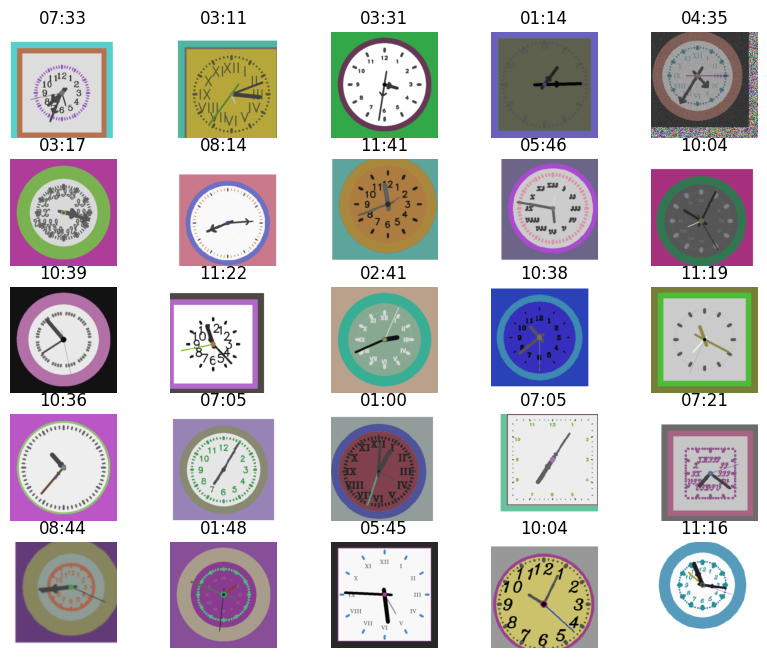

In [ ]:

import matplotlib.pyplot as plt

# Function to denormalize the images
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse the normalization: (tensor * std + mean)

# Fetch a batch of images and labels from the dataloader
images, labels = next(iter(train_dataloader))

# Create a plot to visualize the images and their associated labels
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(cols * rows):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = denormalize(img)  # Reverse the normalization

    hour, minute = labels[i].int().numpy()  # Get the labels and convert to integers

    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"{hour:02d}:{minute:02d}")  # Display the label as HH:MM
    plt.axis("off")
    plt.imshow(img)

plt.show()


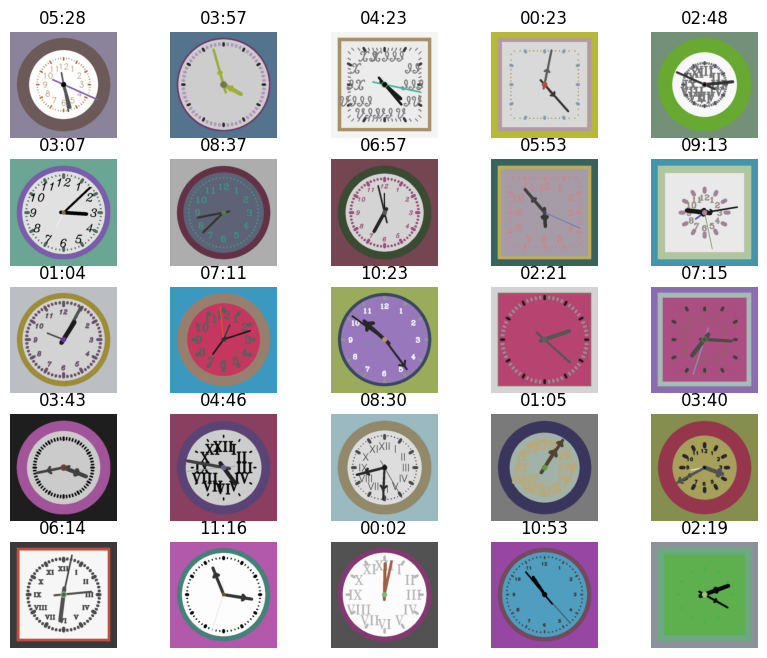

In [ ]:
import matplotlib.pyplot as plt

# Function to denormalize the images
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse the normalization: (tensor * std + mean)

# Fetch a batch of images and labels from the dataloader
images, labels = next(iter(test_dataloader))

# Create a plot to visualize the images and their associated labels
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(cols * rows):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = denormalize(img)  # Reverse the normalization

    hour, minute = labels[i].int().numpy()  # Get the labels and convert to integers

    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"{hour:02d}:{minute:02d}")  # Display the label as HH:MM
    plt.axis("off")
    plt.imshow(img)

plt.show()


The code blocks below refer to part b:

The ResNet-26 architecture designed for predicting clock times from images includes several key features to ensure effective training and accurate regression. The network consists of four main convolutional blocks with residual connections or skip connections. These connections help mitigate the vanishing gradient problem by allowing gradients to flow directly through the network, preserving the learning ability of deeper layers. Overall we have 26 layers as each block layer has 2 further blocks.

Batch normalization layers are used after each convolutional layer within the residual blocks. Batch normalization normalizes the output of the previous activation layer, stabilizing and accelerating the training process. This is particularly beneficial for larger datasets and higher-resolution images, such as the 256x256 clock images used in this project.

Dropout layers are included to prevent overfitting. Dropout randomly sets a fraction of the input units to zero during training, forcing the network to learn redundant representations and enhancing its generalization capability. This regularization technique is important for a model with approximately 11 million parameters, ensuring that the model learns to generalize well to unseen data.

The network is tailored for regression tasks, specifically the prediction of hours and minutes from clock images. At the end of the network, a sigmoid activation function scales the output values between 0 and 1, which are then rescaled to match the desired ranges for hours and minutes (0-11 for hours and 0-59 for minutes). This scaling is essential for maintaining the model's focus on the regression task.

Adaptive average pooling is employed before the final fully connected layer to reduce the spatial dimensions of the feature maps to a fixed size, regardless of the input image size. This technique ensures that the subsequent fully connected layers receive a consistent input size, simplifying the network design and improving computational efficiency.

Overall, this ResNet-based architecture, with its integration of batch normalization, dropout, and adaptive average pooling, is structured to handle the regression task of predicting clock times from high-resolution images effectively.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# Ensure you have the updated model and dataset code from previous steps

# Set up the device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('CUDA' if torch.cuda.is_available() else 'CPU')

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = self.downsample(x)
        x = self.convblock(x)
        x = x + identity
        x = self.relu(x)
        return x

class SmallerResNet(nn.Module):
    def __init__(self):
        super(SmallerResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        #self.layer5 = self._make_layer(256, 512, 3, stride=2)

        self.globalpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512, 2)  # For regression: predicting hours and minutes

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.layer5(x)

        x = self.globalpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.sigmoid(x)  # Apply sigmoid to output
        scaled_output = torch.empty_like(x)

        scaled_output[:, 0] = x[:, 0] * 11  # Scale to range [0, 11] for hours
        scaled_output[:, 1] = x[:, 1] * 59  # Scale to range [0, 59] for minutes

        return scaled_output

# Instantiate the model
model = SmallerResNet().to(device)




CUDA


In [ ]:
# Count number of trainable parameters in network to compare with other models
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)
# Initially = 11,537,666


11537666


In [ ]:
# Put some random data through to check sizes look correct

# Create random input data
x = torch.randn(32, 3, 256, 256)

# Move the input data to the same device as the model
x = x.to(device)

# Pass the data through the model
y = model(x)

# Print the output shape
print(y.shape)


torch.Size([32, 2])


In [ ]:
from IPython.display import Javascript, display

# Function to keep the session alive with a visual indicator
def keep_alive():
    display(Javascript('''
        function ClickConnect(){
            console.log("Clicking on reconnect button to keep the session alive...");
            var reconnectButton = document.querySelector("colab-toolbar-button#connect");
            if (reconnectButton) {
                reconnectButton.click();
                var clickIndicator = document.createElement("div");
                clickIndicator.textContent = "Clicked connect at " + new Date().toLocaleTimeString();
                clickIndicator.style.background = "lightgreen";
                clickIndicator.style.padding = "10px";
                clickIndicator.style.marginTop = "10px";
                document.body.appendChild(clickIndicator);
            }
        }
        setInterval(ClickConnect, 60000);
    '''))

keep_alive()


<IPython.core.display.Javascript object>

PART C:
For the loss function we initially attemped to create a loss function that converts the hours to minutes as well to obtain the absolute error in distances squared. We decided to squate it 0 essentially useing mse loss to account for l2 regularization so as not to overfit on training data. However this resulted in a large loss landscape and despite trying RMSProp, SGD with momentum and Adam optimisers we always stagnated around the 60 and 70 minute marks.

We also attemoted using circular data by using module 720 to convert the minutes into the right distance. This accoutn for the fact that time is circular and 11 o clock is closer to 1 oclock. However, doing this made our loss function non differentiable - the weight swere not evolving.

A compromise was made to just use the Mean squared error loss of the hour and time together. At the very least it resulted in a loss that was traversible and differentiable although it would not perfecctly indicate our closeness to the actual metric we wanted to train for which is minutes. Since we did not convert hours to mionutes even a small error of 1 was considered good even if it meant we were off by an hour. However it did result in our loss as well as absolute error in minutes to go down.

The absolute time in minutes was properly calculated for plotting by accounting for the circular nature of time by using module 720 and obtaining the smaller time distance for both hours and minutes (since each hour and minute difference can be interpreted as having 2 distances: 1 o clock is both 2 hours away from 11 o clock but it is also 10 hours away in the other direction)



Epoch [1/100], Iteration [100/750], Loss: 145.5128
Epoch [1/100], Iteration [200/750], Loss: 133.5747
Epoch [1/100], Iteration [300/750], Loss: 141.0481
Epoch [1/100], Iteration [400/750], Loss: 153.6043
Epoch [1/100], Iteration [500/750], Loss: 148.0338
Epoch [1/100], Iteration [600/750], Loss: 165.6395
Epoch [1/100], Iteration [700/750], Loss: 200.5296
Train loss over epoch 1: 163.7978, Error in minutes: 180.3840
Test loss at epoch 1: 160.5483, Error in minutes: 177.6170
Epoch [2/100], Iteration [100/750], Loss: 137.9431
Epoch [2/100], Iteration [200/750], Loss: 125.5786
Epoch [2/100], Iteration [300/750], Loss: 150.3124
Epoch [2/100], Iteration [400/750], Loss: 166.8452
Epoch [2/100], Iteration [500/750], Loss: 134.7490
Epoch [2/100], Iteration [600/750], Loss: 161.6274
Epoch [2/100], Iteration [700/750], Loss: 159.6581
Train loss over epoch 2: 157.9833, Error in minutes: 180.1861
Test loss at epoch 2: 161.4671, Error in minutes: 177.8250
Epoch [3/100], Iteration [100/750], Loss: 14

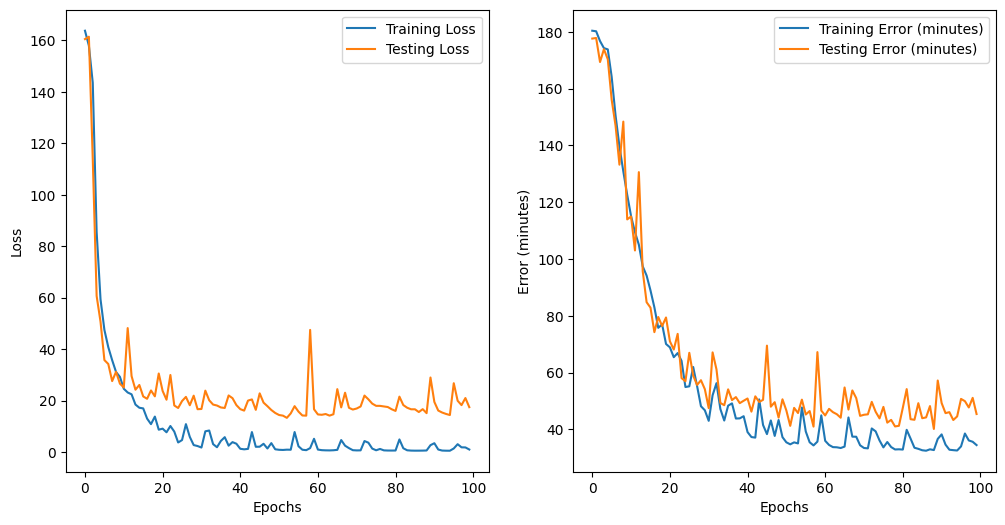

In [ ]:

num_epochs = 100
batch_size = 32  # Updated batch size

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use Mean Squared Error Loss for regression
loss_func = nn.MSELoss()

# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_dataloader.dataset) / batch_size)
training_losses = []
training_errors = []
testing_losses = []
testing_errors = []

for epoch in range(num_epochs):

    # One epoch on the training set
    model.train()
    total_loss = 0
    total_error = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = loss_func(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)


        predicted_total_minutes = (output[:, 0].int() * 60 + output[:, 1].int()) % 720
        true_total_minutes = (labels[:, 0].int() * 60 + labels[:, 1].int()) % 720
        diff1 = torch.abs(predicted_total_minutes - true_total_minutes)
        diff2 = 720 - diff1
        time_diff = torch.min(diff1, diff2)
        total_error += torch.sum(time_diff).item()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss /= len(train_dataloader.dataset)
    total_error /= len(train_dataloader.dataset)
    training_losses.append(total_loss)
    training_errors.append(total_error)
    print('Train loss over epoch {}: {:.4f}, Error in minutes: {:.4f}'.format(epoch + 1, total_loss, total_error))

    # One epoch on the test set
    model.eval()
    total_loss = 0
    total_error = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_func(output, labels)
            total_loss += loss.item() * inputs.size(0)


            # Calculate the absolute error in minutes
            predicted_total_minutes = (output[:, 0].int() * 60 + output[:, 1].int()) % 720
            true_total_minutes = (labels[:, 0].int() * 60 + labels[:, 1].int()) % 720
            diff1 = torch.abs(predicted_total_minutes - true_total_minutes)
            diff2 = 720 - diff1
            time_diff = torch.min(diff1, diff2)
            total_error += torch.sum(time_diff).item()

    total_loss /= len(test_dataloader.dataset)
    total_error /= len(test_dataloader.dataset)
    testing_losses.append(total_loss)
    testing_errors.append(total_error)
    print('Test loss at epoch {}: {:.4f}, Error in minutes: {:.4f}'.format(epoch + 1, total_loss, total_error))

# Plotting the loss and error curves for visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), training_losses, label='Training Loss')
plt.plot(range(num_epochs), testing_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), training_errors, label='Training Error (minutes)')
plt.plot(range(num_epochs), testing_errors, label='Testing Error (minutes)')
plt.xlabel('Epochs')
plt.ylabel('Error (minutes)')
plt.legend()

plt.show()



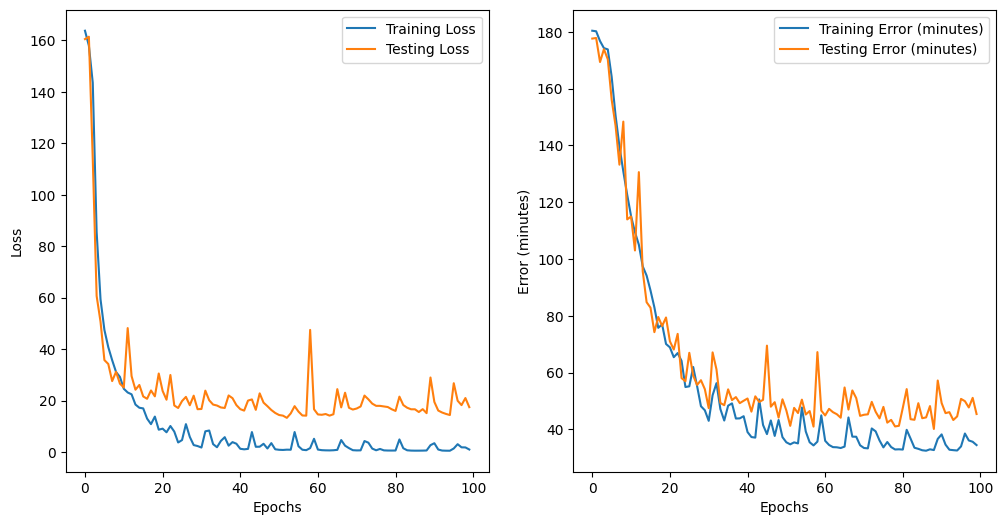
---
PART D:
We plotted both the loss function value and the absolute error in minutes. The image below does not represent that. The performance of our network training and test is plotted above.

For the chosen loss function Adam optimiser obtained the quickest learning convergence while RSMProp and SGD stagnated from the very start or made little progress after 10 epochs despite multiple learning rates tried.

Adam consistently showed progress so we used that. It is the more flexible option as it combined both RMSProp and SGD. It is relatively insentivite to hyperparameters so most likely to work out of the box as well.

We obtained a steady convergence at a learning rate  of 0.001 for a batch size of 32. A batch size of 32was used so we have more epochs per minibatch. It means the learning process if slower but we obtain better feature extraction but making hte learning more granular for all the different clock variations.


---


Learning rates above this also led to stagnation and so did higher batch sizes which led to large genralization gaps early. as shown below

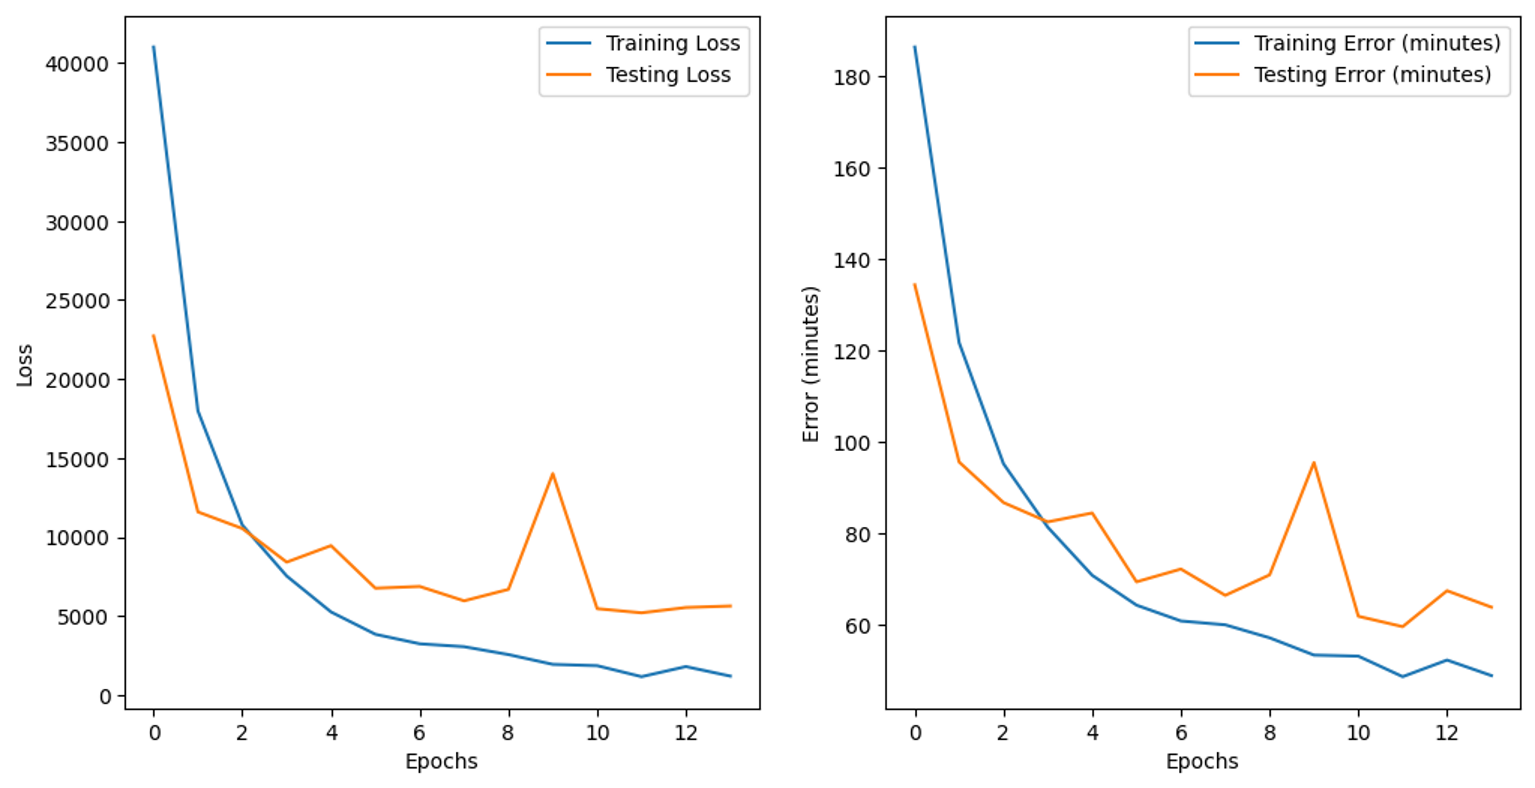


In [ ]:
torch.save(model.state_dict(), 'weights.pkl')

# **Q5: EVALUATION + PREDICT**


In [ ]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = self.downsample(x)
        x = self.convblock(x)
        x = x + identity
        x = self.relu(x)
        return x

class TimePredictionNetwork(nn.Module):
    def __init__(self):
        super(TimePredictionNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.globalpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512, 2)  # For regression: predicting hours and minutes

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.layer5(x)

        x = self.globalpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.sigmoid(x)  # Apply sigmoid to output
        scaled_output = torch.empty_like(x)

        scaled_output[:, 0] = x[:, 0] * 11  # Scale to range [0, 11] for hours
        scaled_output[:, 1] = x[:, 1] * 59  # Scale to range [0, 59] for minutes

        return scaled_output

def predict(images):
    # Determine which device the input tensor is on
    device = torch.device("cuda" if images.is_cuda else "cpu")

    model = TimePredictionNetwork()  # Add your model init parameters here if you have any
    # Move to same device as input images
    model = model.to(device)
    images = images.to(device)

    # Load network weights
    model.load_state_dict(torch.load('weights.pkl', map_location=device))
    # Put model in evaluation mode
    model.eval()

    with torch.no_grad():
        # Pass images to model
        predicted_times = model(images)

    return predicted_times


# Function to collect all predictions from the test dataloader
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_errors = []
    with torch.no_grad():
        for images, labels in dataloader:
            predictions = predict(images)
            # Compute absolute error in minutes using circular time logic
            predicted_total_minutes = (predictions[:, 0].int() * 60 + predictions[:, 1].int()) % 720
            true_total_minutes = (labels[:, 0].int() * 60 + labels[:, 1].int()) % 720
            diff1 = torch.abs(predicted_total_minutes - true_total_minutes)
            diff2 = 720 - diff1
            time_diff = torch.min(diff1, diff2)
            all_errors.extend(time_diff.cpu().numpy())
    return all_errors

# Assuming you have already defined and trained your model, or loaded pretrained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimePredictionNetwork().to(device)
model.load_state_dict(torch.load('weights.pkl', map_location=device))

# Collect errors for the entire test dataset
all_errors = evaluate_model(model, test_dataloader)

# Calculate and print the median error
median_error = np.median(all_errors)
print(f'Median Error in Minutes: {median_error:.2f}')

# Optionally, you can print or analyze individual errors
for idx, error in enumerate(all_errors):
    print(f"Test Image {idx+1}: Error in minutes: {error:.2f}")



Median Error in Minutes: 60.00

The code blocks below refer to part (e) of question 5:

The median error in minutes is:
* Median Error in Minutes: 60.00

We decided to further analyse why this is below.


---

We can see that in the images below for a random batch we are correctly predicting time time with minimal error. However, we are not as accurate in predicting the hour, we are off my one hour is some of them which contributes to the median error.

This can be attributed to the loss function where we did not convert the time to minutes. While we attempted to use many different loss funcitons including converting the entire time to minutes as well as converting it to circular minutes by using module 720 (there are 720 minutes in 12 hour clocks) it still led to similar results. The chosen loss function simply made it easier to train and converge.

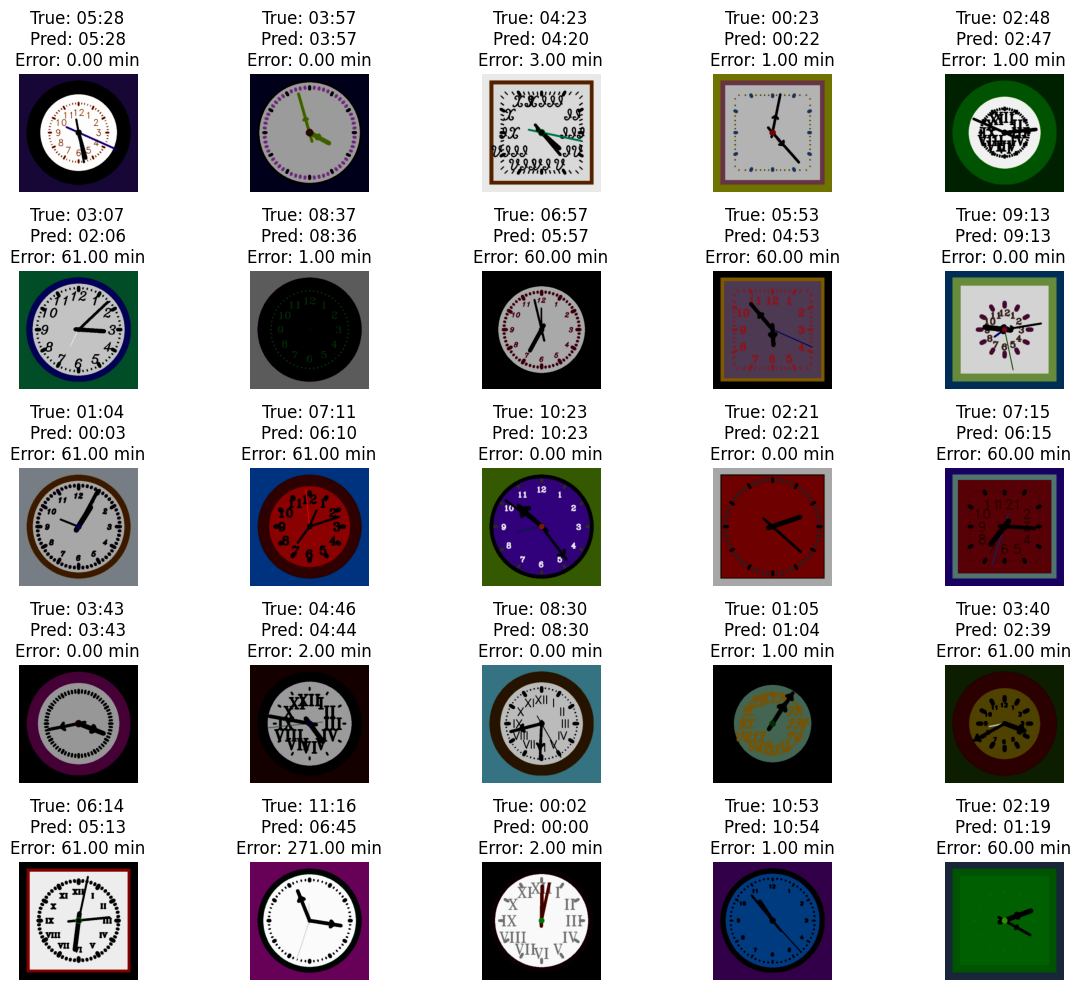

In [ ]:
import torch
import matplotlib.pyplot as plt

# Ensure your model is in evaluation mode
model.eval()

# Run a test batch through the network
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)
output = model(images)

# Move outputs and labels to CPU for visualization
output = output.cpu()
labels = labels.cpu()
images = images.cpu()

# Calculate the absolute error in minutes for each image-label pair
errors_in_minutes = []
for i in range(len(images)):
    predicted_total_minutes = (int(output[i, 0]) * 60 + int(output[i, 1])) % 720
    true_total_minutes = (labels[i, 0] * 60 + labels[i, 1]) % 720
    diff1 = torch.abs(predicted_total_minutes - true_total_minutes)
    diff2 = 720 - diff1
    time_diff = torch.min(diff1, diff2)
    errors_in_minutes.append(time_diff.item())

# Display first 25 images with predicted and true labels, and the absolute error in minutes
figure = plt.figure(figsize=(12, 10))
for i in range(25):
    figure.add_subplot(5, 5, i+1)
    true_time = "{:02d}:{:02d}".format(int(labels[i, 0].item()), int(labels[i, 1].item()))
    pred_time = "{:02d}:{:02d}".format(int(output[i, 0].item()), int(output[i, 1].item()))
    error_in_minutes = errors_in_minutes[i]
    plt.title(f"True: {true_time}\nPred: {pred_time}\nError: {error_in_minutes:.2f} min")
    plt.axis("off")
    plt.imshow(images[i].permute(1, 2, 0).numpy())  # convert from CHW to HWC for visualization
plt.tight_layout()
plt.show()




---

